# Geodetic motion in Schwarzschild geometry

### The metric and the geodesic equation

The metric of the Schwarzschild space around a not charged, not spinnig black hole is $$ ds^2 = -(1-\frac{2GM}{c^2 r})c^2 dt^2 +(1-\frac{2GM}{c^2 r})^{-1} dr^2 + r^2 d\theta^2 + r^2 \sin(\theta)^2 d\phi^2 $$ 
The metric is described by $ g_{\mu \nu} = diag(-(1-\frac{2GM}{c^2 r}), (1-\frac{2GM}{c^2 r})^{-1}, r^2, r^2\sin(\theta)^2) $ 
 
The evolution of a massive body in geodesic motion is described by
$$ \begin{equation}
    \begin{cases}
      \frac{dx^\mu}{d \tau}= u^\mu\\
      \frac{du^\alpha}{d \tau} + \Gamma^\alpha_{\beta \gamma}u^\beta u^\gamma = 0
    \end{cases}\
\end{equation} $$
The equation can be integrated in the proper time to obtain the coordinate time and the position of the body $ x^\mu = (t, r, \theta, \phi) $ 
 
  
The non-zero Christoffel symbols with $ R_S = \frac{GM}{c^2} $, are

$$ \begin{matrix}
  \Gamma^t_{rt}= \frac{R_S}{r(r-2R_S)}   &   \Gamma^r_{tt}= \frac{R_S(r-2R_S)}{r^3} &   \Gamma^r_{rr}= -\frac{R_S}{r(r-2R_S)} \\ 
  \Gamma^r_{\theta\theta}= -(r-2R_S)   &   \Gamma^r_{\phi\phi}= -(r-2R_S)\sin^2\theta  &  \Gamma^\theta_{r\theta}= \frac{1}{r}  \\
 \Gamma^\phi_{r\phi}= \frac{1}{r} &   \Gamma^\theta_{\phi\phi}= -\sin\theta\cos\theta  &   \Gamma^\phi_{\theta\phi}= \frac{\cos \theta}{\sin \theta} \\

\end{matrix} $$

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import pandas as pd
from scipy.integrate import solve_ivp

### Definitions of the metric and the Christoffel symbols

In [2]:
# The metric depends on the point where it is calculated

def metric(Rs):
  return lambda x: np.diag([-(1-2*Rs/x[1]),(1-2*Rs/x[1])**-1, x[1]**2, (x[1]*np.sin(x[2]))**2])

# Christoffel symbols

def Chr(x, Rs):
  r, theta = x[1], x[2]
  ch = np.zeros((4,4,4))
  ch[1][0][0] = Rs*(r-2*Rs)/r**3      # r-tt
  ch[0][1][0] = Rs/(r*(r-2*Rs))    # t-rt
  ch[0][0][1] = Rs/(r*(r-2*Rs))    # t-tr
  
  ch[1][1][1] = -Rs/(r*(r-2*Rs))    # r-rr
  
  ch[1][2][2] = -(r-2*Rs)     # r-theta theta
  ch[2][1][2] = 1/r    # theta - r theta
  ch[2][2][1] = 1/r     # theta - theta r
  
  ch[1][3][3] = -(r-2*Rs)*np.sin(theta)**2   # r- phi phi
  ch[3][1][3] = 1/r    # phi- r phi
  ch[3][3][1] = 1/r    # phi- phi r
  
  ch[2][3][3] = -np.sin(theta)*np.cos(theta)   # theta - phi phi
  ch[3][2][3] = np.cos(theta)/np.sin(theta)   # phi - theta phi
  ch[3][3][2] = np.cos(theta)/np.sin(theta)   # phi - phi theta
  
  return ch

def Christoffel(Rs):
  return lambda x: Chr(x,Rs)

def dot(a,b,g): #Doct product with the metric
  return np.dot(b,np.dot(g, a))

def spher2cart(x):  #Spherical to cartesian coordinates
  r, theta, phi = x[0], x[1], x[2]
  return (r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta))
  

In [3]:
G, M, c = 1.0, 1.0, 1.0
Rs = G*M/c**2

print(f'The Schwarzschild radius is {Rs:.3e}')
g = metric(Rs)
christoffel = Christoffel(Rs)

The Schwarzschild radius is 1.000e+00


In [4]:
#Initial position and speed

x = (1e2, 0.5*np.pi, 0)  # (r, theta, phi)
v = (0,1e-3,8e-2)         # (v_r, v_theta, v_phi) in c units

x_cart = spher2cart(x)
print(f'The initial position is (r: {x[0]:.3e}, theta: {x[1]:.3e}, phi: {x[2]:.3e}) or (x: {x_cart[0]:.3e}, y: {x_cart[1]:.3e}, z: {x_cart[2]:.3e})')

dx = (v[0], v[1]/x[0], v[2]/(x[0]*np.sin(x[1]))) #dx/dt: dr = v_r, dtheta = v_theta/r, dphi = v_phi/(r*sin(theta))
print(f'The initial velocity is (v_r: {v[0]:.3e}, v_theta: {v[1]:.3e}, v_phi: {v[2]:.3e}) or (dr/dt: {dx[0]:.3e}, dtheta/dt: {dx[1]:.3e}, dphi/dt: {dx[2]:.3e})')
print(f'The total velocity is {np.linalg.norm(v):.3e} c')

#Initial 4-vectors
x = np.array([0, x[0], x[1], x[2]])

# u is found by using u*u = -1 and u0 = dt/dtau
u = np.array([1, dx[0], dx[1], dx[2]])
u0 = (-1/dot(u,u,g(x)))**0.5
u = u0*u

print(f'The 4-position is {x}')
print(f'The 4-velocity is {u}')

The initial position is (r: 1.000e+02, theta: 1.571e+00, phi: 0.000e+00) or (x: 1.000e+02, y: 0.000e+00, z: 6.123e-15)
The initial velocity is (v_r: 0.000e+00, v_theta: 1.000e-03, v_phi: 8.000e-02) or (dr/dt: 0.000e+00, dtheta/dt: 1.000e-05, dphi/dt: 8.000e-04)
The total velocity is 8.001e-02 c
The 4-position is [  0.         100.           1.57079633   0.        ]
The 4-velocity is [1.01346777e+00 0.00000000e+00 1.01346777e-05 8.10774213e-04]


In [5]:
def f(tau, y):
  x, u = y[0:4], y[4:]
  return np.concatenate([u,-np.dot(np.dot(u, christoffel(x)), u)])

t0, tf = 0, 1e4

y0 = np.concatenate([x,u])
Y = solve_ivp(f, t_span=(t0, tf), y0=y0, t_eval = np.linspace(t0,tf,10000), rtol=1e-9)

planet = pd.DataFrame({'T':Y.t, 't':Y.y[0], 'r':Y.y[1], 'theta':Y.y[2], 'phi':Y.y[3], 'ut':Y.y[4], 'ur':Y.y[5], 'utheta':Y.y[6], 'uphi':Y.y[7]})
planet.head()

,T,t,r,theta,phi,ut,ur,utheta,uphi
0,0.0000,0.000000,100.000000,1.570796,0.000000,1.013468,0.000000,0.00001,0.000811
1,1.0001,1.013569,99.999982,1.570806,0.000811,1.013468,-0.000036,0.00001,0.000811
2,2.0002,2.027138,99.999928,1.570817,0.001622,1.013468,-0.000072,0.00001,0.000811
3,3.0003,3.040707,99.999837,1.570827,0.002433,1.013468,-0.000109,0.00001,0.000811
4,4.0004,4.054277,99.999710,1.570837,0.003243,1.013468,-0.000145,0.00001,0.000811


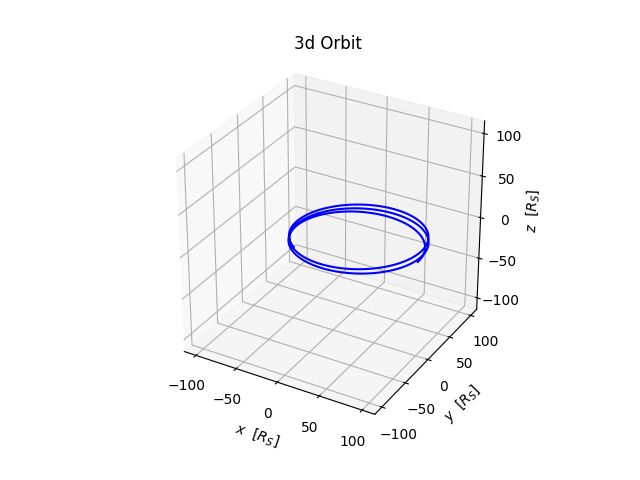

In [6]:
fig = plt.figure('orbit')
ax = fig.add_subplot(projection='3d')
ax.set_title('3d Orbit')
ax.set_aspect('equal')

max_r = 1.1*max(planet['r'])
ax.set_xlabel(r'$x$  $ [R_S]$')
ax.set_ylabel(r'$y$  $ [R_S]$')
ax.set_zlabel(r'$z$  $ [R_S]$')
ax.set_xlim([-max_r, max_r])
ax.set_ylim([-max_r, max_r])
ax.set_zlim([-max_r, max_r])

planet['x'] = planet['r']*np.sin(planet['theta'])*np.cos(planet['phi'])
planet['y'] = planet['r']*np.sin(planet['theta'])*np.sin(planet['phi'])
planet['z'] = planet['r']*np.cos(planet['theta'])

ax.plot(planet['x'], planet['y'], planet['z'], 'b-')